In [1]:
import pandas as pd

# Load the CSV file to examine its structure and content
data = pd.read_csv('Loan.csv')

# Display the first few rows of the dataset
data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [2]:
len(data)

20000

In [3]:
# Check for missing values (optional step to clean the data)
print(data.isnull().sum())

ApplicationDate               0
Age                           0
AnnualIncome                  0
CreditScore                   0
EmploymentStatus              0
EducationLevel                0
Experience                    0
LoanAmount                    0
LoanDuration                  0
MaritalStatus                 0
NumberOfDependents            0
HomeOwnershipStatus           0
MonthlyDebtPayments           0
CreditCardUtilizationRate     0
NumberOfOpenCreditLines       0
NumberOfCreditInquiries       0
DebtToIncomeRatio             0
BankruptcyHistory             0
LoanPurpose                   0
PreviousLoanDefaults          0
PaymentHistory                0
LengthOfCreditHistory         0
SavingsAccountBalance         0
CheckingAccountBalance        0
TotalAssets                   0
TotalLiabilities              0
MonthlyIncome                 0
UtilityBillsPaymentHistory    0
JobTenure                     0
NetWorth                      0
BaseInterestRate              0
Interest

In [4]:
data["ApplicationDate"] = pd.to_datetime(data["ApplicationDate"], errors="coerce")
data['ApplicationYear'] = data['ApplicationDate'].dt.year
data['ApplicationMonth'] = data['ApplicationDate'].dt.month
data['ApplicationDay'] = data['ApplicationDate'].dt.day
data['ApplicationWeekday'] = data['ApplicationDate'].dt.weekday
data = data.drop(columns=['ApplicationDate'])  # Drop the original column

In [5]:
approved = data[data['LoanApproved']==True]
print('Number of approved loans: ', len(approved))
not_approved = data[data['LoanApproved']==False]
print('Number of non-approved loans: ', len(not_approved))

Number of approved loans:  4780
Number of non-approved loans:  15220


## Some things about handling class imbalance

- **SMOTE**: Generates synthetic samples for the minority class by interpolating between existing samples. Works well for numeric features and preserves the original feature distribution. Use with care if your features are highly imbalanced or categorical.
- **Randomly remove instances from the majority class** to balance the dataset. Effective when you have a lot of data, but it risks losing valuable information.
- Most machine learning algorithms (e.g., Logistic Regression, Random Forest, XGBoost) allow you to **assign weights to classes**, making the model penalize misclassification of the minority class more heavily. This doesn’t alter the dataset, avoiding the risks of overfitting or losing information.
So, could rather than balancing the data, assign class weights during training to account for the imbalance while preserving the original approval rate.


- Combine SMOTE with techniques like feature engineering or noise injection.
- Always evaluate the model on the original, unbalanced test dataset to ensure predictions align with reality.

## Try SMOTE

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter

# Encode the target variable if it is categorical
label_encoder = LabelEncoder()
data['LoanApproved'] = label_encoder.fit_transform(data['LoanApproved'])  # 0 = Not Approved, 1 = Approved

# Separate features (X) and target (y)
X = data.drop('LoanApproved', axis=1)  # All features

# Perform one-hot encoding for categorical features
X = pd.get_dummies(X, drop_first=True)

y = data['LoanApproved']  # Target variable

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle numerical scaling if required
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Scale training data
X_test = scaler.transform(X_test)        # Scale test data

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution before and after SMOTE
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

# # Convert target names to strings
# target_names = list(map(str, label_encoder.classes_))

# # Evaluate the model
# print(classification_report(y_test, y_pred, target_names=target_names))

Before SMOTE: Counter({0: 12176, 1: 3824})
After SMOTE: Counter({0: 12176, 1: 12176})


In [33]:
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
# from sklearn.metrics import precision_recall_curve, roc_curve
# import matplotlib.pyplot as plt

# def plot_results(y_pred):
#     # Predict class probabilities for ROC-AUC and PR curve
#     y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
#     # Convert target names to strings
#     target_names = list(map(str, label_encoder.classes_))
#     # Classification Report
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred, target_names=target_names))
    
#     # F1-Score (for the minority class, `LoanApproved == 1`)
#     f1_minority = f1_score(y_test, y_pred, pos_label=1)
#     print(f"F1-Score for the minority class (LoanApproved == 1): {f1_minority:.4f}")
    
#     # ROC-AUC
#     roc_auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC-ROC: {roc_auc:.2f}")
    
#     # Confusion Matrix
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))
    
#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.figure(figsize=(10, 6))
#     plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend()
#     plt.show()
    
#     # Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_test, y_proba)
#     plt.figure(figsize=(10, 6))
#     plt.plot(recall, precision, label=f'Precision-Recall Curve (F1 = {f1_minority:.4f})')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision-Recall Curve')
#     plt.legend()
#     plt.show()

In [61]:
# from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, accuracy_score
# from sklearn.metrics import precision_recall_curve, roc_curve
# import matplotlib.pyplot as plt

# def plot_results(y_pred):
#     # Predict class probabilities for ROC-AUC and PR curve
#     y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
#     # Convert target names to strings
#     target_names = list(map(str, label_encoder.classes_))
    
#     # Training Accuracy
#     train_pred = model.predict(X_train_resampled)
#     train_accuracy = accuracy_score(y_train_resampled, train_pred)
#     print(f"Training Accuracy: {train_accuracy:.4f}")
    
#     # Classification Report
#     print("\nClassification Report (Test Set):")
#     print(classification_report(y_test, y_pred, target_names=target_names))
    
#     # F1-Score (for the minority class, `LoanApproved == 1`)
#     f1_minority = f1_score(y_test, y_pred, pos_label=1)
#     print(f"F1-Score for the minority class (LoanApproved == 1): {f1_minority:.4f}")
    
#     # ROC-AUC
#     roc_auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC-ROC (Test Set): {roc_auc:.2f}")
    
#     # Confusion Matrix
#     print("\nConfusion Matrix (Test Set):")
#     print(confusion_matrix(y_test, y_pred))
    
#     # ROC Curve
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.figure(figsize=(10, 6))
#     plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend()
#     plt.show()
    
#     # Precision-Recall Curve
#     precision, recall, _ = precision_recall_curve(y_test, y_proba)
#     plt.figure(figsize=(10, 6))
#     plt.plot(recall, precision, label=f'Precision-Recall Curve (F1 = {f1_minority:.4f})')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision-Recall Curve')
#     plt.legend()
#     plt.show()
    


In [79]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

def plot_results(y_pred):
    # Predict class probabilities for ROC-AUC and PR curve
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    
    # Convert target names to strings
    target_names = list(map(str, label_encoder.classes_))
    
    # Training Accuracy
    train_pred = model.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, train_pred)
    print(f"Training Accuracy: {train_accuracy:.4f}")
    
    # Test Accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    diff_acc = train_accuracy-test_accuracy
    print(f'Difference training & testing accuracy: {diff_acc:.4f}')
    perc_diff = ((train_accuracy-test_accuracy)/train_accuracy)*100
    print(f'Percentage difference: {perc_diff:.4f}')
    
    # Classification Report
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # F1-Score (for the minority class, `LoanApproved == 1`)
    f1_minority = f1_score(y_test, y_pred, pos_label=1)
    print(f"F1-Score for the minority class (LoanApproved == 1): {f1_minority:.4f}")
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC (Test Set): {roc_auc:.2f}")
    
    # Confusion Matrix
    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_test, y_pred))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (F1 = {f1_minority:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()


Training Accuracy: 0.9964
Test Accuracy: 0.9892
Difference training & testing accuracy: 0.0072
Percentage difference: 0.7179

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3044
           1       0.98      0.97      0.98       956

    accuracy                           0.99      4000
   macro avg       0.99      0.98      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9774
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3029   15]
 [  28  928]]


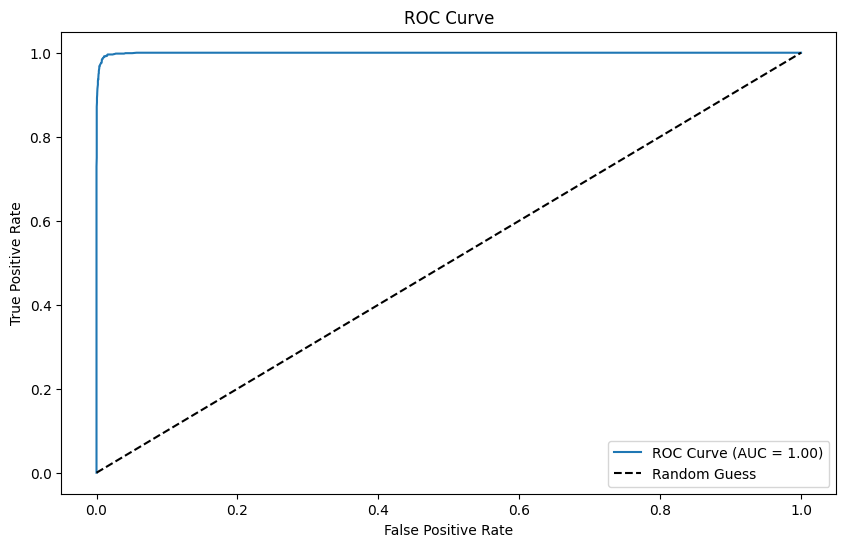

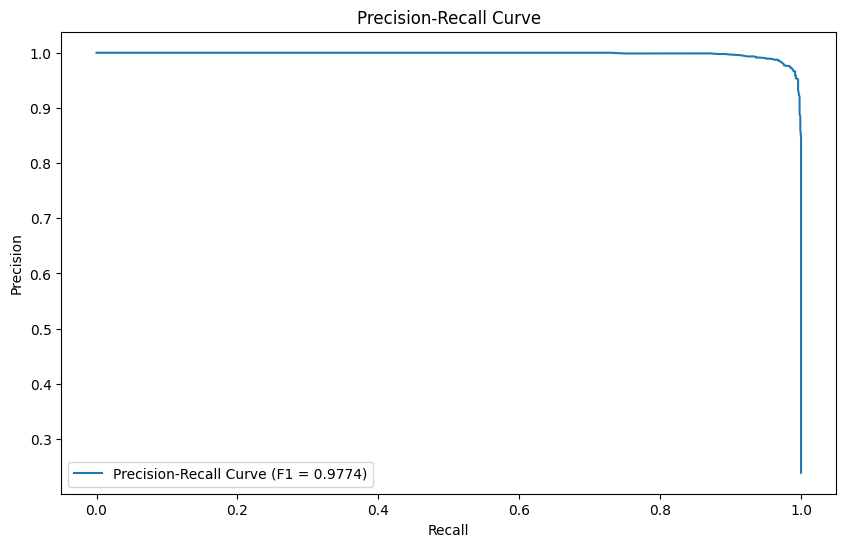

In [80]:
plot_results(y_pred)

## ADASYN (Adaptive Synthetic Sampling)

Similar to SMOTE but focuses on creating synthetic samples for harder-to-learn areas of the feature space.  
Pro: Can improve decision boundaries for imbalanced datasets.  
Con: May introduce more noise compared to SMOTE

In [81]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print("After ADASYN:", Counter(y_train_resampled))

After ADASYN: Counter({1: 12293, 0: 12176})


In [82]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model.predict(X_test)

Training Accuracy: 1.0000
Test Accuracy: 0.9895
Difference training & testing accuracy: 0.0105
Percentage difference: 1.0500

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3044
           1       0.97      0.98      0.98       956

    accuracy                           0.99      4000
   macro avg       0.98      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9781
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3019   25]
 [  17  939]]


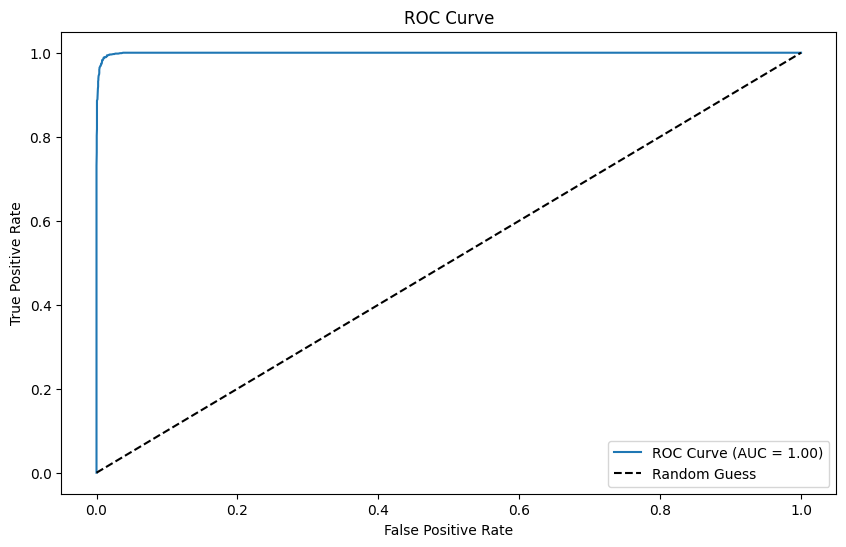

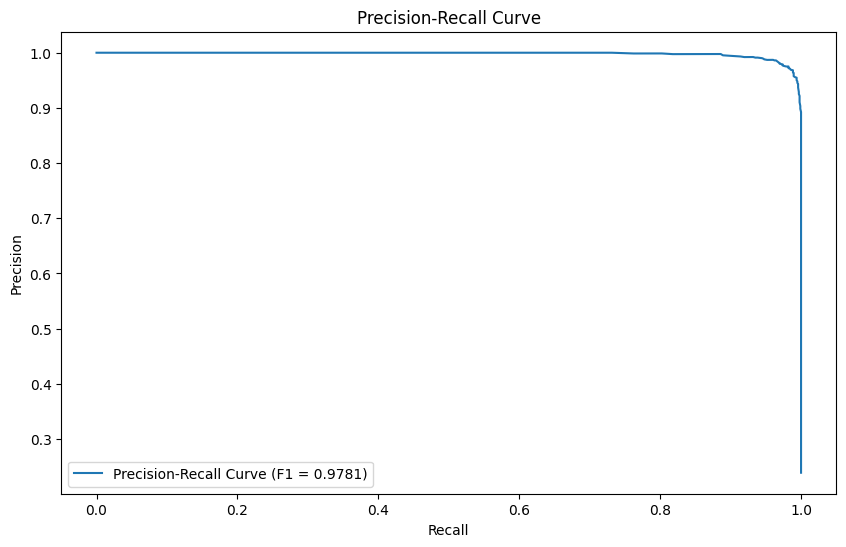

In [83]:
plot_results(y_pred)

## Uniform Sampling

Disadvantages:  
- By repeating instances from the minority class, it does not introduce any new information or variability.  
- It may lead to overfitting, as the model sees the same examples multiple times.

In [84]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter

# Uniform Sampling: Randomly duplicate minority class samples until classes are balanced

# Separate the minority and majority class data
minority_class = 1  # 1 is the minority class
X_minority = X_train[y_train == minority_class]
y_minority = y_train[y_train == minority_class]

majority_count = Counter(y_train)[0]
minority_count = Counter(y_train)[1]

# Calculate the number of samples needed to balance the classes
samples_to_generate = majority_count - minority_count

# Uniformly sample from the minority class with replacement
synthetic_samples = X_minority[np.random.choice(X_minority.shape[0], samples_to_generate, replace=True)]
synthetic_labels = np.array([minority_class] * samples_to_generate)

# Combine synthetic samples with the original training data
X_train_augmented = np.vstack((X_train, synthetic_samples))
y_train_augmented = np.hstack((y_train, synthetic_labels))

# Check class distribution after uniform sampling
print("Before Augmentation:", Counter(y_train))
print("After Augmentation:", Counter(y_train_augmented))

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_augmented, y_train_augmented)

# Predict on the test set
y_pred = model.predict(X_test)

Before Augmentation: Counter({0: 12176, 1: 3824})
After Augmentation: Counter({np.int64(0): 12176, np.int64(1): 12176})


Training Accuracy: 0.9988
Test Accuracy: 0.9895
Difference training & testing accuracy: 0.0093
Percentage difference: 0.9285

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3044
           1       0.98      0.98      0.98       956

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9781
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3022   22]
 [  20  936]]


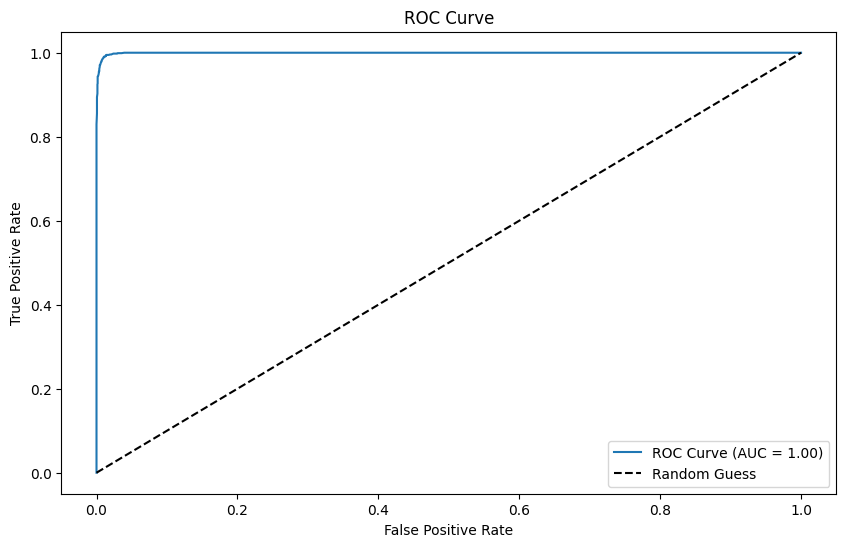

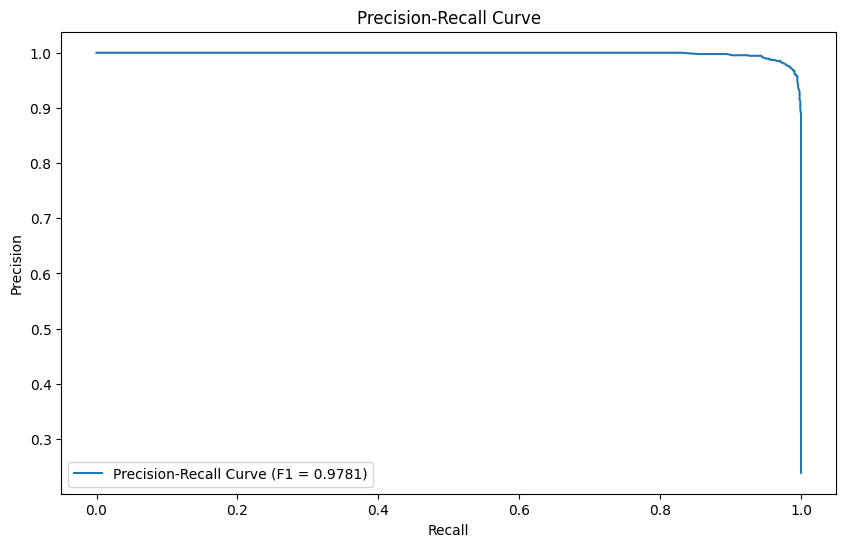

In [85]:
plot_results(y_pred)

## Stratified Sampling

- Unlike simple oversampling, stratified resampling carefully replicates the feature patterns within the minority class, reducing the risk of introducing noise or bias. (preserves minority class distribution)

- Since the minority class samples are representative, the model is less likely to overfit compared to methods like uniform oversampling. (avoids overfitting) 

- Balancing the classes ensures the model does not disproportionately favor the majority class, leading to better performance metrics, particularly for the minority class. (improves model performance)

In [69]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from collections import Counter

# Separate the majority and minority class
minority_class = 1
X_minority = X_train[y_train == minority_class]
y_minority = y_train[y_train == minority_class]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

# Perform stratified resampling to balance the classes
X_minority_resampled, y_minority_resampled = resample(
    X_minority, y_minority,
    replace=True,                   # Allow replacement for resampling
    n_samples=len(y_majority),      # Match the majority class size
    random_state=42                 # Ensure reproducibility
)

# Combine resampled minority class with the original majority class
X_train_augmented = np.vstack((X_majority, X_minority_resampled))
y_train_augmented = np.hstack((y_majority, y_minority_resampled))

# Check class distribution after stratified resampling
print("Before Augmentation:", Counter(y_train))
print("After Augmentation:", Counter(y_train_augmented))

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_augmented, y_train_augmented)

# Predict on the test set
y_pred = model.predict(X_test)

Before Augmentation: Counter({0: 12176, 1: 3824})
After Augmentation: Counter({np.int64(0): 12176, np.int64(1): 12176})


Training Accuracy: 0.9987
Test Accuracy: 0.9892

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3044
           1       0.98      0.98      0.98       956

    accuracy                           0.99      4000
   macro avg       0.98      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9776
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3020   24]
 [  19  937]]


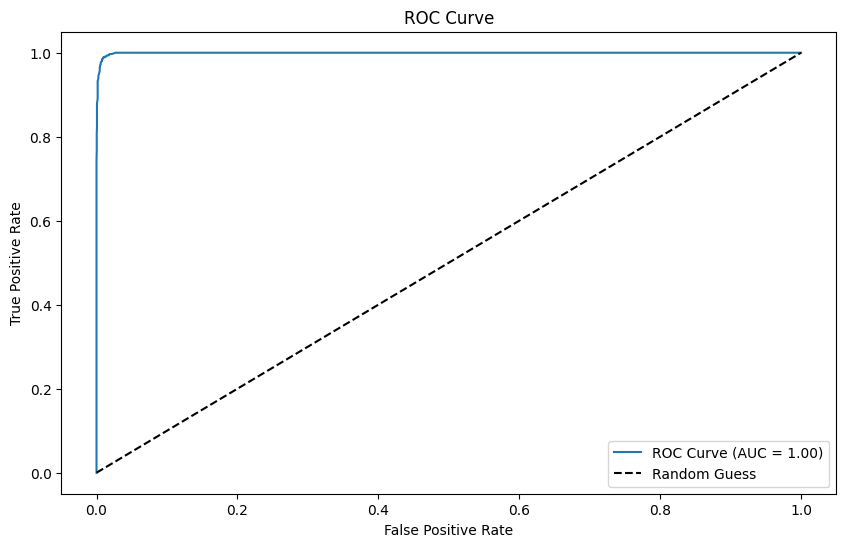

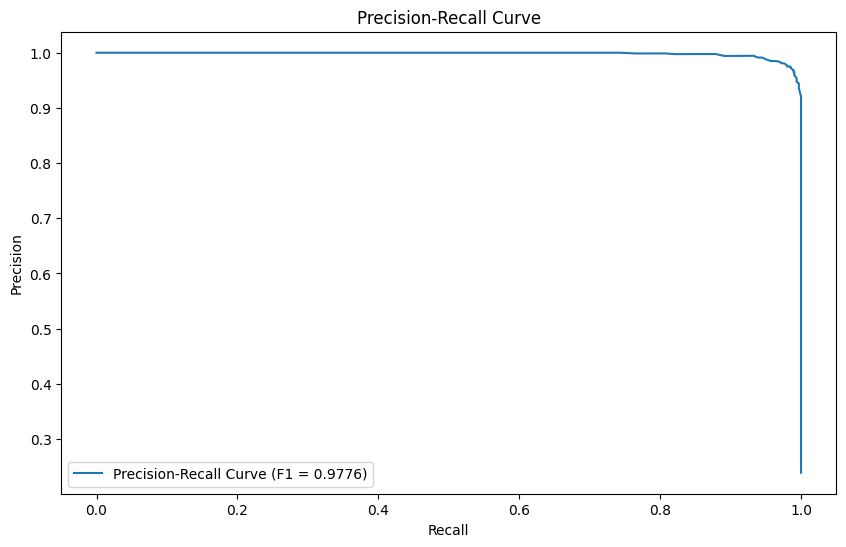

In [70]:
plot_results(y_pred)

## GMM

In [71]:
from sklearn.mixture import GaussianMixture
import numpy as np
from collections import Counter

# Separate the minority class data
minority_class = 1 
X_minority = X_train[y_train == minority_class]

# Fit a Gaussian Mixture Model to the minority class
gmm = GaussianMixture(n_components=2, random_state=42)  # Adjust components as needed
gmm.fit(X_minority)

# Calculate the number of synthetic samples needed for balance
majority_count = Counter(y_train)[0]
minority_count = Counter(y_train)[1]
samples_to_generate = majority_count - minority_count

# Generate synthetic samples
synthetic_samples, _ = gmm.sample(n_samples=samples_to_generate)

# Add synthetic samples to the training set
X_train_augmented = np.vstack((X_train, synthetic_samples))
y_train_augmented = np.hstack((y_train, [minority_class] * samples_to_generate))

print("Before Augmentation:", Counter(y_train))
print("After Augmentation:", Counter(y_train_augmented))

Before Augmentation: Counter({0: 12176, 1: 3824})
After Augmentation: Counter({np.int64(0): 12176, np.int64(1): 12176})


In [72]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_augmented, y_train_augmented)

# Predict on the test set
y_pred = model.predict(X_test)

Training Accuracy: 0.9977
Test Accuracy: 0.9898

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3044
           1       0.98      0.98      0.98       956

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9785
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3024   20]
 [  21  935]]


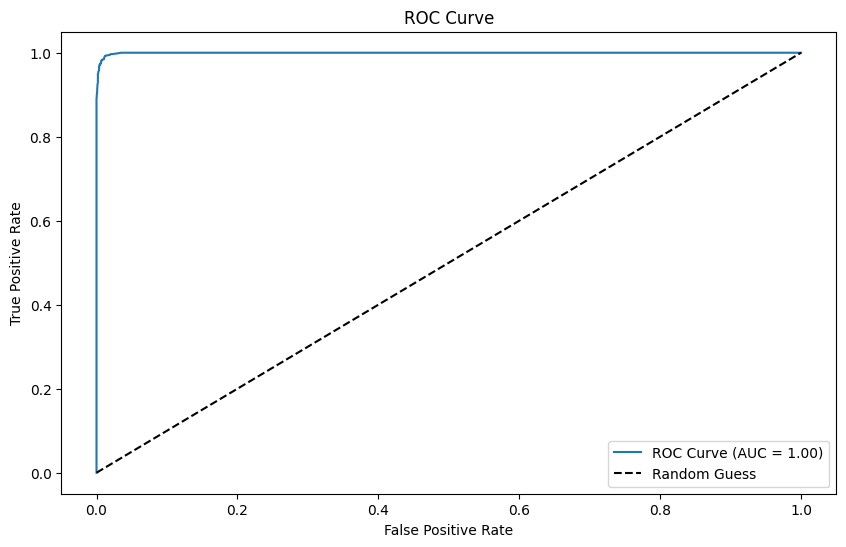

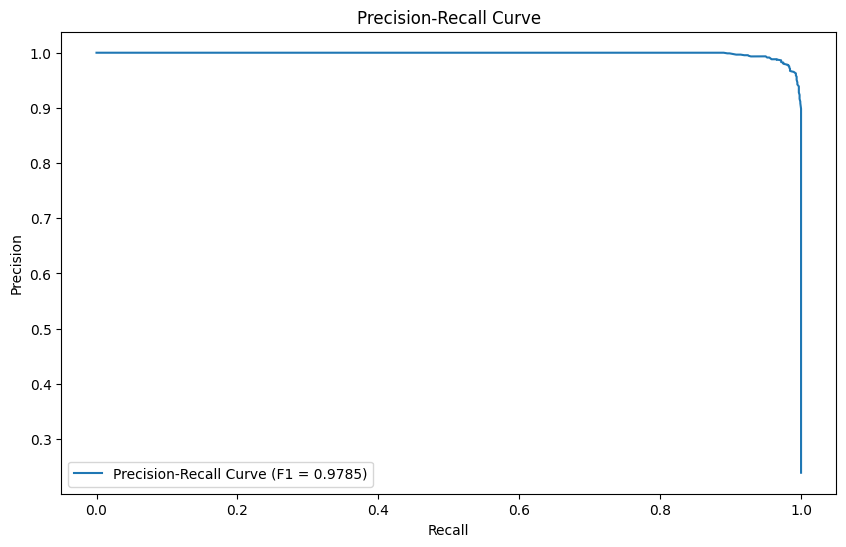

In [73]:
plot_results(y_pred)

## KMeans

In [74]:
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter

# Separate the minority class data
minority_class = 1  # Assuming 1 is the minority class
X_minority = X_train[y_train == minority_class]

# Fit a KMeans model to the minority class
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(X_minority)

# Calculate the number of synthetic samples needed for balance
majority_count = Counter(y_train)[0]
minority_count = Counter(y_train)[1]
samples_to_generate = majority_count - minority_count

# Generate synthetic samples by sampling around cluster centroids
synthetic_samples = []
centroids = kmeans.cluster_centers_

for _ in range(samples_to_generate):
    # Randomly pick a cluster centroid
    random_centroid = centroids[np.random.choice(len(centroids))]
    # Add random noise to the centroid to generate synthetic data
    synthetic_sample = random_centroid + np.random.normal(0, 0.01, size=random_centroid.shape)
    synthetic_samples.append(synthetic_sample)

synthetic_samples = np.array(synthetic_samples)

# Add synthetic samples to the training set
X_train_augmented = np.vstack((X_train, synthetic_samples))
y_train_augmented = np.hstack((y_train, [minority_class] * samples_to_generate))

# Check class distribution before and after augmentation
print("Before Augmentation:", Counter(y_train))
print("After Augmentation:", Counter(y_train_augmented))

Before Augmentation: Counter({0: 12176, 1: 3824})
After Augmentation: Counter({np.int64(0): 12176, np.int64(1): 12176})


In [75]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_augmented, y_train_augmented)

# Predict on the test set
y_pred = model.predict(X_test)

Training Accuracy: 0.9964
Test Accuracy: 0.9892

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3044
           1       0.98      0.97      0.98       956

    accuracy                           0.99      4000
   macro avg       0.99      0.98      0.99      4000
weighted avg       0.99      0.99      0.99      4000

F1-Score for the minority class (LoanApproved == 1): 0.9774
AUC-ROC (Test Set): 1.00

Confusion Matrix (Test Set):
[[3029   15]
 [  28  928]]


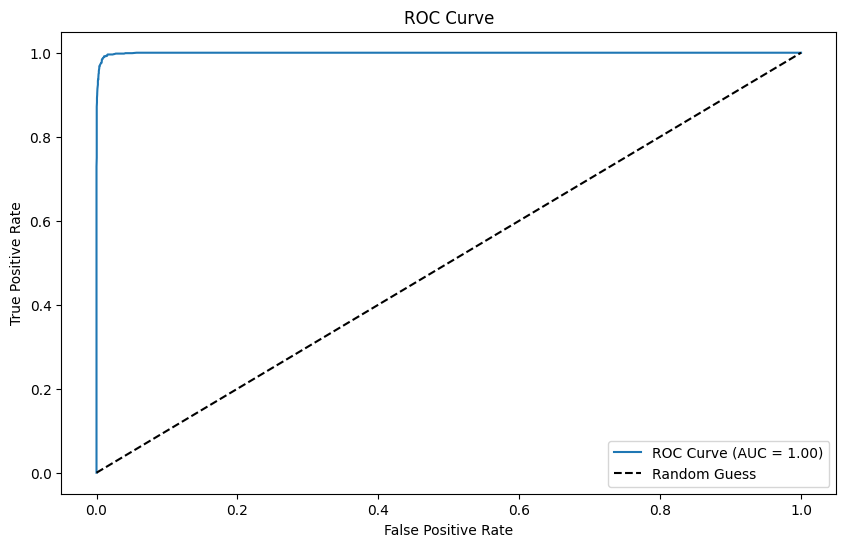

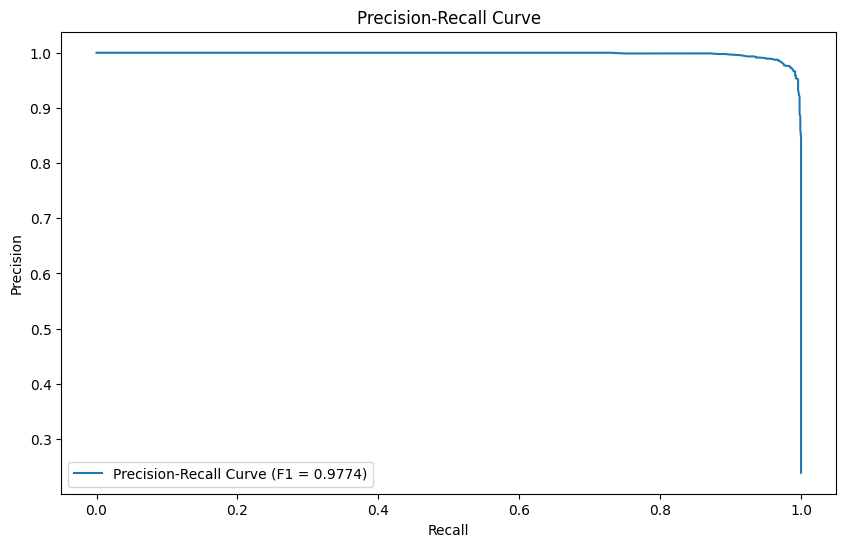

In [76]:
plot_results(y_pred)

In [ ]:
### Model Comparison and Visualization
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create dictionary to store model results
model_results = {
    "Random Forest": (model, y_pred),
    "Logistic Regression": (model, y_pred),
    "SVM": (svm_model, y_pred_svm),
    "KNN": (knn_model, y_pred_knn),
    "XGBoost": (xgb_model, y_pred_xgb),
}

# Calculate metrics for each model
metrics = {}
for name, (model, predictions) in model_results.items():
    metrics[name] = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision": precision_score(y_test, predictions),
        "Recall": recall_score(y_test, predictions),
        "F1": f1_score(y_test, predictions),
    }

# Create comparison plot
metrics_df = pd.DataFrame(metrics).T
plt.figure(figsize=(12, 6))
metrics_df.plot(kind="bar")
plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Feature Engineering
# Create new features
loan_data["DebtToAssets"] = (
    loan_data["TotalDebtToIncomeRatio"] * loan_data["TotalAssets"]
)
loan_data["IncomeToAge"] = loan_data["AnnualIncome"] / loan_data["Age"]
loan_data["CreditScoreToHistory"] = (
    loan_data["CreditScore"] / loan_data["LengthOfCreditHistory"]
)

# Feature Selection using Random Forest importance
from sklearn.ensemble import RandomForestClassifier

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": predictor_variables, "importance": rf_selector.feature_importances_}
).sort_values("importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()

### Hyperparameter Tuning Example (for Random Forest)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring="f1"
)

rf_grid.fit(X_train, y_train)
print("Best parameters:", rf_grid.best_params_)
print("Best score:", rf_grid.best_score_)

# Cross-validation scores
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf_grid.best_estimator_, X_train, y_train, cv=5, scoring="f1"
)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())


In [ ]:
from sklearn.metrics import precision_recall_curve  # Add this import

# First ensure feature names are properly formatted
feature_names = np.array(predictor_variables)  # Convert to numpy array

### 1. Feature Selection Refinement
best_rf = rf_grid.best_estimator_
important_features = pd.DataFrame(
    {"feature": predictor_variables, "importance": best_rf.feature_importances_}
).sort_values("importance", ascending=False)

# Select top N most important features
N = 10
top_features = important_features.head(N)["feature"].tolist()

### 2. Model Interpretability using SHAP
# Create SHAP explainer and values
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Basic SHAP summary plot without feature names
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.show()

### 3. Error Analysis with Confusion Matrix
y_pred_rf = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix (%)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### 4. Prediction Distribution Analysis
y_prob = best_rf.predict_proba(X_test)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(y_prob[:, 1], bins=50)
plt.title("Distribution of Prediction Probabilities")
plt.xlabel("Probability of Approval")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob[:, 1])
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

# Calculate and print optimal threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"Optimal threshold: {optimal_threshold}")

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(important_features.head(10))


In [ ]:
### 1. Create Focused Model with Top Features
top_5_features = important_features["feature"].head(5).tolist()

# Train model with only top features
X_top = X[top_5_features]
X_train_top, X_test_top, y_train, y_test = train_test_split(
    X_top, y, test_size=0.2, random_state=42
)

# Train RF with best parameters using only top features
focused_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
focused_rf.fit(X_train_top, y_train)

### 2. Apply Optimal Threshold
y_prob_focused = focused_rf.predict_proba(X_test_top)
y_pred_focused = (y_prob_focused[:, 1] > optimal_threshold).astype(int)

# Compare performance metrics
print("\nPerformance Metrics with Optimal Threshold:")
print(classification_report(y_test, y_pred_focused))


### 3. Create Risk Categories
def get_risk_category(prob):
    if prob < 0.2:
        return "Very High Risk"
    elif prob < 0.4:
        return "High Risk"
    elif prob < 0.6:
        return "Medium Risk"
    elif prob < 0.8:
        return "Low Risk"
    else:
        return "Very Low Risk"


# Apply risk categories to predictions
risk_probs = focused_rf.predict_proba(X_test_top)[:, 1]
risk_categories = [get_risk_category(prob) for prob in risk_probs]

# Show distribution of risk categories
risk_dist = pd.Series(risk_categories).value_counts()
plt.figure(figsize=(10, 6))
risk_dist.plot(kind="bar")
plt.title("Distribution of Risk Categories")
plt.xlabel("Risk Category")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4. Feature Interaction Analysis
if len(top_5_features) >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(
        X_test_top[top_5_features[0]],
        X_test_top[top_5_features[1]],
        c=risk_probs,
        cmap="RdYlGn",
    )
    plt.colorbar(label="Approval Probability")
    plt.xlabel(top_5_features[0])
    plt.ylabel(top_5_features[1])
    plt.title(f"Interaction between Top 2 Features")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

# Define the models and their predictions
models = {
    "Random Forest": (model, y_pred),
    "Logistic Regression": (model, y_pred),
    "SVM": (svm_model, y_pred_svm),
    "KNN": (knn_model, y_pred_knn),
    "XGBoost": (xgb_model, y_pred_xgb),
}

# Plot ROC curves
plt.figure(figsize=(10, 6))

for name, (model, y_pred) in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

In [ ]:
### 1. Import Libraries and Load Data (assuming this is already done)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### 2. Random Forest (Previously Implemented)
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), rf_params, cv=5, scoring="f1"
)
rf_grid.fit(X_train, y_train)
print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Best F1 Score:", rf_grid.best_score_)

### 3. Logistic Regression
lr_params = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring="f1")
lr_grid.fit(X_train, y_train)
print("\nLogistic Regression Best Parameters:", lr_grid.best_params_)
print("Best F1 Score:", lr_grid.best_score_)

### 4. XGBoost
xgb_params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
    "min_child_weight": [1, 3],
}

xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=5, scoring="f1")
xgb_grid.fit(X_train, y_train)
print("\nXGBoost Best Parameters:", xgb_grid.best_params_)
print("Best F1 Score:", xgb_grid.best_score_)

### 5. KNN
knn_params = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring="f1")
knn_grid.fit(X_train, y_train)
print("\nKNN Best Parameters:", knn_grid.best_params_)
print("Best F1 Score:", knn_grid.best_score_)

### 6. Gradient Boosting
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
}
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring="f1"
)
gb_grid.fit(X_train, y_train)
print("\nGradient Boosting Best Parameters:", gb_grid.best_params_)
print("Best F1 Score:", gb_grid.best_score_)

### 7. AdaBoost
ada_params = {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1.0]}
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42), ada_params, cv=5, scoring="f1"
)
ada_grid.fit(X_train, y_train)
print("\nAdaBoost Best Parameters:", ada_grid.best_params_)
print("Best F1 Score:", ada_grid.best_score_)

### 8. Extra Trees
et_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5],
}
et_grid = GridSearchCV(
    ExtraTreesClassifier(random_state=42), et_params, cv=5, scoring="f1"
)
et_grid.fit(X_train, y_train)
print("\nExtra Trees Best Parameters:", et_grid.best_params_)
print("Best F1 Score:", et_grid.best_score_)

### 9. Neural Network (MLP)
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "activation": ["relu", "tanh"],
    "alpha": [0.1, 0.001],
}
mlp_grid = GridSearchCV(
    MLPClassifier(random_state=42, max_iter=1000), mlp_params, cv=5, scoring="f1"
)
mlp_grid.fit(X_train, y_train)
print("\nNeural Network Best Parameters:", mlp_grid.best_params_)
print("Best F1 Score:", mlp_grid.best_score_)

### 10. Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_score = cross_val_score(gnb_model, X_train, y_train, cv=5, scoring="f1").mean()
print("\nGaussian Naive Bayes F1 Score:", gnb_score)

### Combine all models
all_models = {
    "Random Forest": rf_grid.best_estimator_,
    "Logistic Regression": lr_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_,
    "KNN": knn_grid.best_estimator_,
    "Gradient Boosting": gb_grid.best_estimator_,
    "AdaBoost": ada_grid.best_estimator_,
    "Extra Trees": et_grid.best_estimator_,
    "Neural Network": mlp_grid.best_estimator_,
    "Gaussian NB": gnb_model,
}

### Model Comparison
model_scores = {}
for name, model in all_models.items():
    y_pred = model.predict(X_test)
    model_scores[name] = {
        "F1": f1_score(y_test, y_pred),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    }

scores_df = pd.DataFrame(model_scores).T
scores_df = scores_df.sort_values("F1", ascending=False)

print("\nFinal Model Comparison (Sorted by F1 Score):")
print(scores_df)

### Visualizations
# 1. Model Performance Comparison
plt.figure(figsize=(15, 6))
scores_df["F1"].plot(kind="bar")
plt.title("Model Comparison - F1 Scores")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. ROC Curves
plt.figure(figsize=(10, 6))
for name, model in all_models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.show()

# 3. Confusion Matrices
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

for idx, (name, model) in enumerate(all_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix (%)")
    axes[idx].set_ylabel("True Label")
    axes[idx].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()
